# Law 软件包的教程（一）——读取数据并推荐法律

这篇教程教你如何从数据库中导出数据，并且利用字典把所有的文字转换为数字表达形式，从而可以直接使用tensorflow进行深度学习，或scikit learn学习

你可以配合https://chenyangzhu.github.io/sufelaw2019/ 官方文档查看这个介绍

In [22]:
import law
import pandas as pd
import numpy as np
import mysql.connector
import sklearn.model_selection
import matplotlib.pyplot as plt

%matplotlib inline

首先，连接数据库，你的账户和密码分别为你的姓名拼音和law+拼音例如：
```
user = 'zhuchenyang'
password = 'law-zhuchenyang'
```

In [2]:
cnx_case = mysql.connector.connect(user="root", password="sufelaw2019",  # 注意修改
                              host="cdb-74dx1ytr.gz.tencentcdb.com",
                              port = "10008",
                              database="law")

在你连接了数据库之后，使用SQL 语言查询任何你想要的数据

数据库的详细构造和可使用的数据类型，可以在[这里](https://chenyangzhu.github.io/sufelaw2019/#/database)查看

In [3]:
data = pd.read_sql('SELECT * FROM Civil WHERE result LIKE "%劳动法%";',con=cnx_case)

# 一、构建embedding model

接下来我们处理NLP，我们直接使用Embedding这个主类来处理。注意：尽管我们**并没有真正做embedding**，但现在的函数就先叫这个名字，embedding可以直接用tensorflow来完成，我们这里做的是cutting，mapping和padding。

In [4]:
mtd = law.embedding.Embedding("./law/dict/dictionary.csv", "./law/dict/jieba_dict.txt")

Building Dictionary from  ./law/dict/dictionary.csv


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.581 seconds.
Prefix dict has been built succesfully.


在这一个embed_pandas文件里，我们对每一条信息做一下处理：

- 首先做entity recognition，即找到其中的被告姓名，原告姓名，并用特定符号代替，从而我们有consistent的人称指代。
- 其次我们用jieba分词cut所有的字符串，得到一系列的string list
- 然后我们把这些string list通过字典map到数字域中，从而得到int list
- 最后，我们利用padding，把所有的字符int list全部拓展到指定的维度，默认为2000个字符。

In [5]:
num_list = mtd.embed_pandas(df=data,targets = "process")

Doing 0 . Total 1183
Doing 20 . Total 1183
Doing 40 . Total 1183
Doing 60 . Total 1183
Doing 80 . Total 1183
Doing 100 . Total 1183
Doing 120 . Total 1183
Doing 140 . Total 1183
Doing 160 . Total 1183
Doing 180 . Total 1183
Doing 200 . Total 1183
Doing 220 . Total 1183
Doing 240 . Total 1183
Doing 260 . Total 1183
Doing 280 . Total 1183
Doing 300 . Total 1183
Doing 320 . Total 1183
Doing 340 . Total 1183
Doing 360 . Total 1183
Doing 380 . Total 1183
Doing 400 . Total 1183
Doing 420 . Total 1183
Doing 440 . Total 1183
Doing 460 . Total 1183
Doing 480 . Total 1183
Doing 500 . Total 1183
Doing 520 . Total 1183
Doing 540 . Total 1183
Doing 560 . Total 1183
Doing 580 . Total 1183
Doing 600 . Total 1183
Doing 620 . Total 1183
Doing 640 . Total 1183
Doing 660 . Total 1183
Doing 680 . Total 1183
Doing 700 . Total 1183
Doing 720 . Total 1183
Doing 740 . Total 1183
Doing 760 . Total 1183
Doing 780 . Total 1183
Doing 800 . Total 1183
Doing 820 . Total 1183
Doing 840 . Total 1183
Doing 860 . Total

In [6]:
mapped_and_padded = np.array(num_list)

In [7]:
mapped_and_padded.shape

(1183, 2000)

In [8]:
mapped_and_padded[:10]

array([[   6,   45,    6, ...,    0,    0,    0],
       [1059,    6,   29, ...,    0,    0,    0],
       [1059,   20,   11, ...,    0,    0,    0],
       ...,
       [1059,    6,  442, ...,    0,    0,    0],
       [1059,    6,  442, ...,    0,    0,    0],
       [1059,    6,  442, ...,    0,    0,    0]])

`mapped_and_padded`矩阵就是我们已经cut、map和pad过的X矩阵了。接下来我们来处理标签y

# 二、使用API 找到文本中出现的全部法律

我们使用`law.utils.find_law_in_series`的函数来调取`result`中出现的所有法律和条款名称

In [9]:
used_law = law.utils.find_law_in_series(data['result'])

In [10]:
used_law[:10]

[[['《中华人民共和国民事诉讼法》', ['第二百五十三条'], []],
  ['《中华人民共和国劳动合同法》', ['第四十四条'], []],
  ['《中华人民共和国劳动法》', ['第四十五条'], []]],
 [['《中华人民共和国民事诉讼法》', ['第一百一十九条', '第一百五十四条'], ['第一百五十四条第一款']],
  ['《最高人民法院关于审理劳动争议案件适用法律若干问题的解释》', ['第一条'], []],
  ['《中华人民共和国劳动法》', ['第二条'], []]],
 [['《中华人民共和国民事诉讼法》', ['第二百五十三条'], []], ['《中华人民共和国劳动法》', ['第三条'], []]],
 [['《中华人民共和国民事诉讼法》', ['第二百五十三条'], []], ['《中华人民共和国劳动法》', ['第三条'], []]],
 [['《中华人民共和国民事诉讼法》', ['第二百五十三条'], []], ['《中华人民共和国劳动法》', ['第三条'], []]],
 [['《中华人民共和国民事诉讼法》', ['第二百五十三条'], []], ['《中华人民共和国劳动法》', ['第三条'], []]],
 [['《中华人民共和国民事诉讼法》', ['第二百五十三条'], []], ['《中华人民共和国劳动法》', ['第三条'], []]],
 [['《中华人民共和国民事诉讼法》', ['第二百五十三条'], []],
  ['《中华人民共和国劳动法》', ['第七十二条', '第七十三条'], []]],
 [['《中华人民共和国民事诉讼法》', ['第二百五十三条'], []], ['《中华人民共和国劳动法》', ['第五十条'], []]],
 [['《中华人民共和国民事诉讼法》', ['第二百五十三条'], []],
  ['《中华人民共和国劳动争议调解仲裁法》', ['第六条'], []],
  ['《中华人民共和国劳动法》', ['第四十四条'], []],
  ['《职工带薪年休假条例》', ['第三条、第五条'], []]]]

可以看到，这个结果是用数组存储的，为了方便之后的回归模型等，我们对每一个case，只选择一条法律（本例为劳动法）和出现的第一条来做后面的回归。

In [11]:
law_list = []
for each_case in used_law:
    case_law = []
    flag = 0
    for each_law in each_case:
        if "劳动法" in each_law[0]:
            try:
                # 注意这里只取了一个法律
                only_one_tiao = each_law[1][0]
            except:
                only_one_tiao = ' '
            case_law = [each_law[0],only_one_tiao]
            flag = 1
    if not flag:
        case_law = [" "]
    law_list.append(case_law)

law_list = pd.DataFrame(law_list)
law_list = law_list.rename(columns={0:"law_used",1:"tiao_used"})

处理结束后，得到了如下的表，这里的index和我们原始的表中的index是一致的。

In [12]:
law_list.head()

,law_used,tiao_used
0,《中华人民共和国劳动法》,第四十五条
1,《中华人民共和国劳动法》,第二条
2,《中华人民共和国劳动法》,第三条
3,《中华人民共和国劳动法》,第三条
4,《中华人民共和国劳动法》,第三条


In [13]:
# 看看我们的y和x的维度是否一致
law_list.shape[0] == mapped_and_padded.shape[0]

True

事实由于我只取了劳动法，所以我们其实只需要tiao即可了，但可以看到tiao其实还有没有请洗干净的，例如none和" "，我们不想要这些数据

In [15]:
# 需要排除的index包括
drop_list = list(law_list[law_list['tiao_used'] == ' '].index)
drop_list.extend(list(law_list[law_list['tiao_used'] == None].index))

drop_list

[96,
 112,
 128,
 230,
 232,
 333,
 351,
 358,
 420,
 495,
 496,
 646,
 808,
 809,
 952,
 991,
 1004,
 1038,
 1048]

我们需要同时在X 和Y中drop这些点

In [17]:
X = np.delete(mapped_and_padded,drop_list,0)
y = law_list.drop(index=drop_list,axis=0)['tiao_used']

最后，我们把y变为数字向量，当然还有很多其他方法，这里只列举一种。

+1 是因为factorize时候会生成一个 -1，所以我们要把他移到0的位置

In [19]:
y = pd.factorize(y)[0] + 1

(array([594., 135., 162.,  25., 102.,  88.,  15.,  23.,  10.,  10.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <a list of 10 Patch objects>)

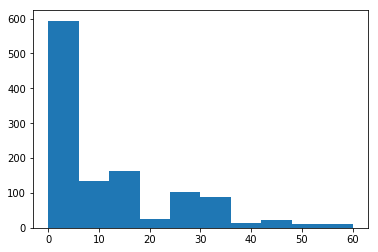

In [20]:
plt.hist(y)

至此，X 和y已经构建完毕，我们接着划分train val 和test

In [23]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=2)

# 三、模型

由于我们的模型还是以deep learning为主，这里随意套一个多分类模型，作为教程示范。

In [25]:
import tensorflow as tf

tf.__version__

'2.0.0-alpha0'

In [28]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(4896, 16)) # 4896是字典的大小
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(61, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          78336     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 61)                1037      
Total params: 79,645
Trainable params: 79,645
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [30]:
history = model.fit(X,y,epochs=200, batch_size=64, validation_data=(X_val, y_val))

Train on 1164 samples, validate on 187 samples
Epoch 1/200
1164/1164 [==============================] - 1s 495us/sample - loss: 4.0378 - acc: 0.0816 - val_loss: 3.8528 - val_acc: 0.1818
Epoch 2/200
1164/1164 [==============================] - 0s 334us/sample - loss: 3.4086 - acc: 0.1718 - val_loss: 2.9947 - val_acc: 0.1818
Epoch 3/200
1164/1164 [==============================] - 0s 323us/sample - loss: 3.0020 - acc: 0.1718 - val_loss: 2.8885 - val_acc: 0.1818
Epoch 4/200
1164/1164 [==============================] - 0s 320us/sample - loss: 2.9560 - acc: 0.1718 - val_loss: 2.8490 - val_acc: 0.1818
Epoch 5/200
1164/1164 [==============================] - 0s 347us/sample - loss: 2.9337 - acc: 0.1718 - val_loss: 2.8291 - val_acc: 0.1818
Epoch 6/200
1164/1164 [==============================] - 0s 330us/sample - loss: 2.9220 - acc: 0.1718 - val_loss: 2.8153 - val_acc: 0.1818
Epoch 7/200
1164/1164 [==============================] - 0s 341us/sample - loss: 2.9144 - acc: 0.1718 - val_loss: 2.814

1164/1164 [==============================] - 0s 314us/sample - loss: 1.7034 - acc: 0.5318 - val_loss: 1.6048 - val_acc: 0.5401
Epoch 60/200
1164/1164 [==============================] - 0s 330us/sample - loss: 1.6797 - acc: 0.5550 - val_loss: 1.5874 - val_acc: 0.5401
Epoch 61/200
1164/1164 [==============================] - 0s 345us/sample - loss: 1.6599 - acc: 0.5576 - val_loss: 1.5718 - val_acc: 0.5989
Epoch 62/200
1164/1164 [==============================] - 0s 355us/sample - loss: 1.6402 - acc: 0.5619 - val_loss: 1.5491 - val_acc: 0.5989
Epoch 63/200
1164/1164 [==============================] - 0s 336us/sample - loss: 1.6181 - acc: 0.5722 - val_loss: 1.5320 - val_acc: 0.5989
Epoch 64/200
1164/1164 [==============================] - 0s 333us/sample - loss: 1.6004 - acc: 0.5790 - val_loss: 1.5083 - val_acc: 0.6043
Epoch 65/200
1164/1164 [==============================] - 0s 351us/sample - loss: 1.5803 - acc: 0.5756 - val_loss: 1.4980 - val_acc: 0.5508
Epoch 66/200
1164/1164 [=========

1164/1164 [==============================] - 0s 324us/sample - loss: 0.7798 - acc: 0.8024 - val_loss: 0.6968 - val_acc: 0.8342
Epoch 118/200
1164/1164 [==============================] - 0s 333us/sample - loss: 0.7683 - acc: 0.8084 - val_loss: 0.6872 - val_acc: 0.8396
Epoch 119/200
1164/1164 [==============================] - 0s 318us/sample - loss: 0.7590 - acc: 0.8084 - val_loss: 0.6809 - val_acc: 0.8396
Epoch 120/200
1164/1164 [==============================] - 0s 324us/sample - loss: 0.7520 - acc: 0.8127 - val_loss: 0.6737 - val_acc: 0.8396
Epoch 121/200
1164/1164 [==============================] - 0s 326us/sample - loss: 0.7423 - acc: 0.8093 - val_loss: 0.6770 - val_acc: 0.8342
Epoch 122/200
1164/1164 [==============================] - 0s 330us/sample - loss: 0.7317 - acc: 0.8144 - val_loss: 0.6616 - val_acc: 0.8342
Epoch 123/200
1164/1164 [==============================] - 0s 329us/sample - loss: 0.7212 - acc: 0.8162 - val_loss: 0.6604 - val_acc: 0.8396
Epoch 124/200
1164/1164 [==

1164/1164 [==============================] - 0s 352us/sample - loss: 0.3737 - acc: 0.9132 - val_loss: 0.3546 - val_acc: 0.8930
Epoch 176/200
1164/1164 [==============================] - 0s 343us/sample - loss: 0.3708 - acc: 0.9141 - val_loss: 0.3383 - val_acc: 0.9091
Epoch 177/200
1164/1164 [==============================] - 0s 325us/sample - loss: 0.3653 - acc: 0.9184 - val_loss: 0.3340 - val_acc: 0.9037
Epoch 178/200
1164/1164 [==============================] - 0s 321us/sample - loss: 0.3636 - acc: 0.9167 - val_loss: 0.3249 - val_acc: 0.9091
Epoch 179/200
1164/1164 [==============================] - 0s 325us/sample - loss: 0.3564 - acc: 0.9227 - val_loss: 0.3318 - val_acc: 0.9091
Epoch 180/200
1164/1164 [==============================] - 0s 345us/sample - loss: 0.3526 - acc: 0.9201 - val_loss: 0.3143 - val_acc: 0.9144
Epoch 181/200
1164/1164 [==============================] - 0s 338us/sample - loss: 0.3485 - acc: 0.9201 - val_loss: 0.3207 - val_acc: 0.8984
Epoch 182/200
1164/1164 [==

In [37]:
loss = history.history['loss']
acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

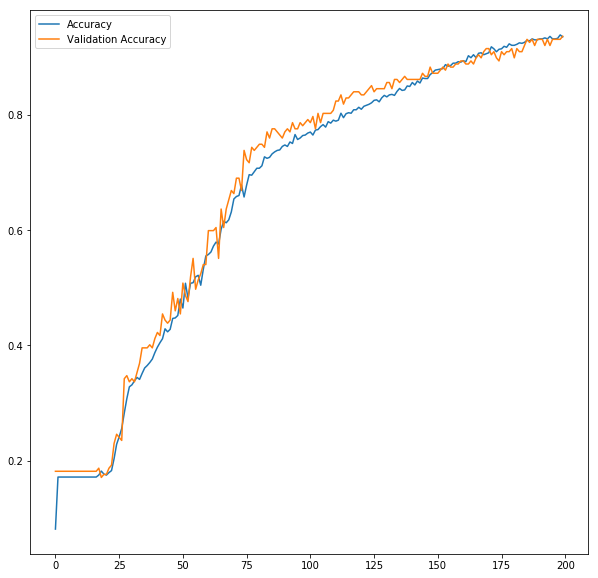

In [44]:
plt.figure(figsize=(10,10))
plt.plot(acc,label="Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()

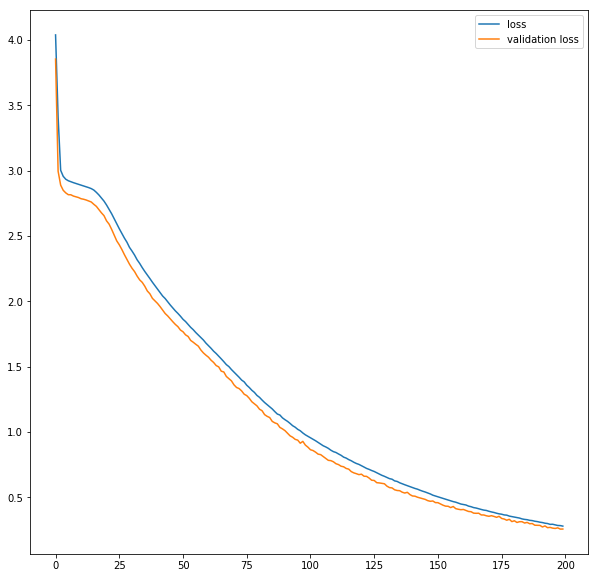

In [45]:
plt.figure(figsize=(10,10))
plt.plot(loss,label="loss")
plt.plot(val_loss,label="validation loss")
plt.legend()

# 总结

结果还是很不错的，至少没有使用RNN的情况下，只做embedding就有这个准确率，还是很不错的。

虽然现在只做了一个劳动法的条的检索，其实如果套上别的法律，按照同样的想法，效果应该很不错。